In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", None)
# load raw transactions
df = pd.read_csv("../data/raw/training.csv")
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [3]:
# data cleaning and date conversion
# we don't need Amount because it's basically sign of Value
df = df.drop(columns=["Amount"])

# ensure timestamp is datetime
df["TransactionStartTime"] = pd.to_datetime(df["TransactionStartTime"])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Value                 95662 non-null  int64              
 12  Tran

# Define snapshot date and compute RFM

In [14]:
# Snapshot date: one day after the last transaction
snapshot_date = df["TransactionStartTime"].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)

Snapshot date: 2019-02-14 10:01:28+00:00


In [15]:
# Compute RFM at customer level
rfm = (
    df
    .groupby("CustomerId")
    .agg(
        Recency=("TransactionStartTime",
                 lambda x: (snapshot_date - x.max()).days),
        Frequency=("TransactionId", "count"),
        Monetary=("Value", "sum"),
    )
)

rfm.head(), rfm.describe()


(                 Recency  Frequency  Monetary
 CustomerId                                   
 CustomerId_1          84          1     10000
 CustomerId_10         84          1     10000
 CustomerId_1001       90          5     30400
 CustomerId_1002       26         11      4775
 CustomerId_1003       12          6     32000,
            Recency    Frequency      Monetary
 count  3742.000000  3742.000000  3.742000e+03
 mean     31.461251    25.564404  2.531025e+05
 std      27.118932    96.929602  2.715877e+06
 min       1.000000     1.000000  5.000000e+01
 25%       6.000000     2.000000  6.500000e+03
 50%      25.000000     7.000000  3.200000e+04
 75%      54.000000    20.000000  1.020600e+05
 max      91.000000  4091.000000  1.049000e+08)

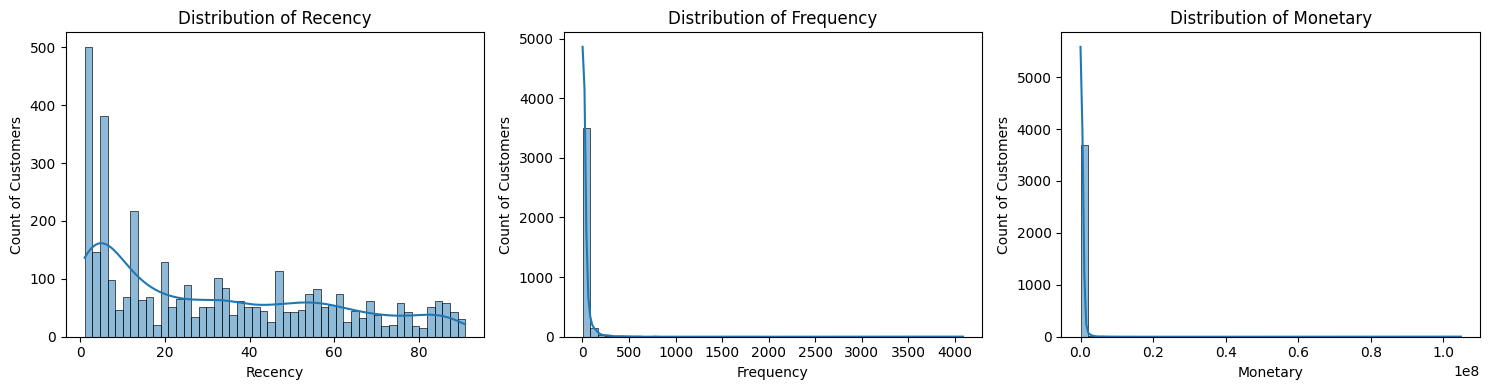

In [16]:
# visualize RFM distribution
plt.figure(figsize=(15, 4))

for i, col in enumerate(["Recency", "Frequency", "Monetary"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count of Customers")

plt.tight_layout()
plt.show()


In [32]:
# Log-transform skewed features to reduce the impact of extreme outliers
rfm["Frequency_log"] = np.log1p(rfm["Frequency"])
rfm["Monetary_log"] = np.log1p(rfm["Monetary"])

rfm[["Recency", "Frequency", "Monetary",
     "Frequency_log", "Monetary_log"]].describe()


,Recency,Frequency,Monetary,Frequency_log,Monetary_log
count,3742.000000,3742.000000,3.742000e+03,3742.000000,3742.000000
mean,31.461251,25.564404,2.531025e+05,2.251714,10.196698
std,27.118932,96.929602,2.715877e+06,1.265347,1.999736
min,1.000000,1.000000,5.000000e+01,0.693147,3.931826
25%,6.000000,2.000000,6.500000e+03,1.098612,8.779711
50%,25.000000,7.000000,3.200000e+04,2.079442,10.373522
75%,54.000000,20.000000,1.020600e+05,3.044522,11.533326
max,91.000000,4091.000000,1.049000e+08,8.316789,18.468518


In [19]:
# check for absurd Monetary outliers
rfm["Monetary"].quantile([0.95, 0.99, 0.999])

0.950    6.100771e+05
0.990    2.298402e+06
0.999    3.524094e+07
Name: Monetary, dtype: float64

In [28]:
# Prepare data for KMeans (using transformed features) 
# clustered on Recency + log-transformed Frequency & Monetary
X_rfm = rfm[["Recency", "Frequency_log", "Monetary_log"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfm)

X_scaled[:5]


array([[ 1.93760472, -1.23189529, -0.49325977],
       [ 1.93760472, -1.23189529, -0.49325977],
       [ 2.15888193, -0.36354942,  0.06278319],
       [-0.20140839,  0.18431583, -0.86289884],
       [-0.7177219 , -0.24170834,  0.08843583]])

In [27]:
# Run KMeans clustering
# Use multiple initializations for stability
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
rfm["cluster"] = kmeans.fit_predict(X_scaled)

rfm["cluster"].value_counts()


cluster
2    1272
1    1254
0    1216
Name: count, dtype: int64

In [33]:
# Cluster profiles (original units and transformed)
cluster_stats_raw = (
    rfm
    .groupby("cluster")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .round(2)
)

cluster_stats_transformed = (
    rfm
    .groupby("cluster")[["Recency", "Frequency_log", "Monetary_log"]]
    .mean()
    .round(2)
)

cluster_stats_raw, cluster_stats_transformed


(         Recency  Frequency   Monetary
 cluster                               
 0          64.41       4.51   36360.90
 1          17.93       5.32   34334.37
 2          13.30      65.65  675974.45,
          Recency  Frequency_log  Monetary_log
 cluster                                      
 0          64.41           1.44          9.08
 1          17.93           1.63          9.39
 2          13.30           3.65         12.06)

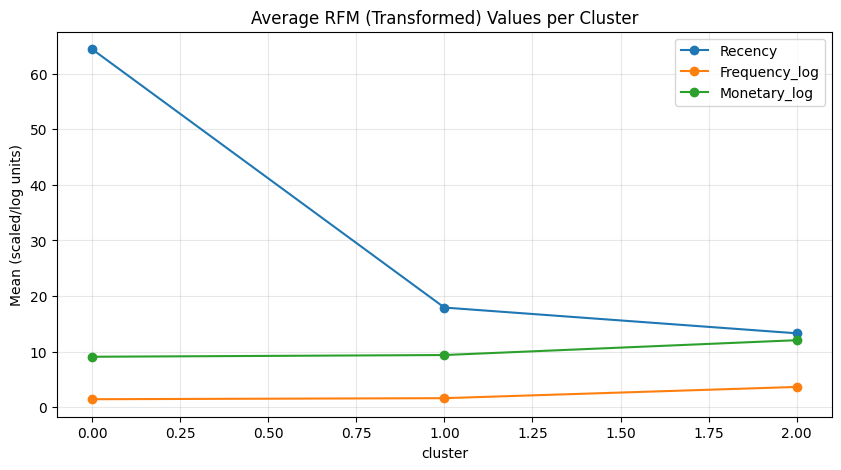

In [34]:
# visualise cluster profiles
plt.figure(figsize=(10, 5))

for col in ["Recency", "Frequency_log", "Monetary_log"]:
    plt.plot(
        cluster_stats_transformed.index,
        cluster_stats_transformed[col],
        marker="o",
        label=col,
    )

plt.title("Average RFM (Transformed) Values per Cluster")
plt.xlabel("cluster")
plt.ylabel("Mean (scaled/log units)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [35]:
# identify high risk clusters
high_risk_cluster = cluster_stats_transformed.sort_values(
    ["Recency", "Frequency_log", "Monetary_log"],
    ascending=[False, True, True]  # worst: high R, low F, low M
).index[0]

print("High-risk cluster:", high_risk_cluster)


High-risk cluster: 0


In [36]:
# creating binary proxy target
rfm["is_high_risk"] = (rfm["cluster"] == high_risk_cluster).astype(int)

print("High-risk label distribution:")
rfm["is_high_risk"].value_counts(), rfm["is_high_risk"].mean()


High-risk label distribution:


(is_high_risk
 0    2526
 1    1216
 Name: count, dtype: int64,
 np.float64(0.324959914484233))

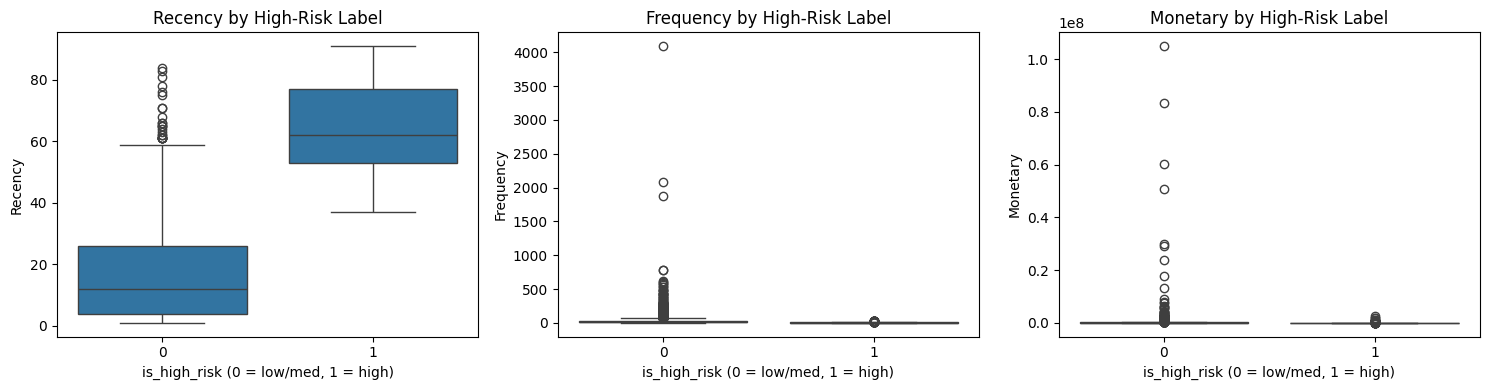

In [37]:
# RFM by risk levels
plt.figure(figsize=(15, 4))

for i, col in enumerate(["Recency", "Frequency", "Monetary"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="is_high_risk", y=col, data=rfm)
    plt.title(f"{col} by High-Risk Label")
    plt.xlabel("is_high_risk (0 = low/med, 1 = high)")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [38]:
# Build final customer-level dataset & save
customer_features = (
    rfm
    .reset_index()  # bring CustomerId back as a column
    .loc[:, [
        "CustomerId",
        "Recency",
        "Frequency",
        "Monetary",
        "Frequency_log",
        "Monetary_log",
        "cluster",
        "is_high_risk",
    ]]
)

customer_features.head(), customer_features.shape

(        CustomerId  Recency  Frequency  Monetary  Frequency_log  Monetary_log  \
 0     CustomerId_1       84          1     10000       0.693147      9.210440   
 1    CustomerId_10       84          1     10000       0.693147      9.210440   
 2  CustomerId_1001       90          5     30400       1.791759     10.322231   
 3  CustomerId_1002       26         11      4775       2.484907      8.471359   
 4  CustomerId_1003       12          6     32000       1.945910     10.373522   
 
    cluster  is_high_risk  
 0        0             1  
 1        0             1  
 2        0             1  
 3        1             0  
 4        1             0  ,
 (3742, 8))

In [40]:
# save the engineered feature
import os
os.getcwd()

# Build absolute path to the processed directory
processed_dir = os.path.abspath("../data/processed")

# Create directory if it doesn't exist
os.makedirs(processed_dir, exist_ok=True)

# File path
output_path = os.path.join(processed_dir, "customer_rfm_with_target.csv")

# Save file
customer_features.to_csv(output_path, index=False)

output_path


'C:\\Users\\jilow\\OneDrive\\Documents\\credit_scoring_loan_models\\credit-score-Loan-model\\data\\processed\\customer_rfm_with_target.csv'